# MNIST 手寫辨識0~9，使用CNN實作

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 20)        1820      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 20)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 20)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 980)               0         
__________

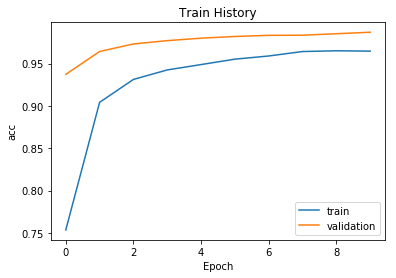

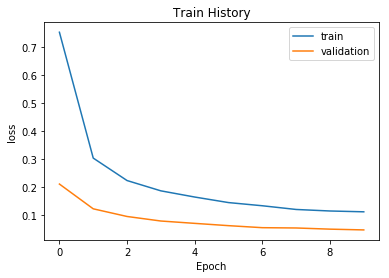

 9952/10000 [============================>.] - ETA: 0s

accuracy= 0.9864
 9952/10000 [============================>.] - ETA: 0s

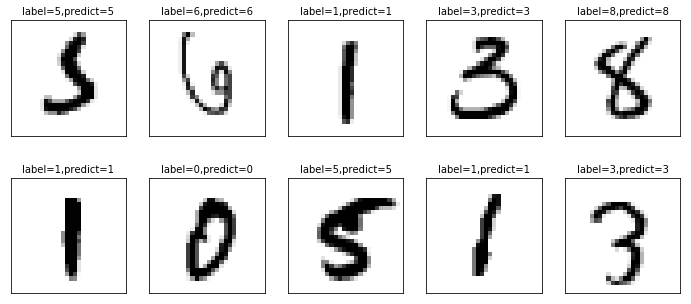

OSError: Unable to create file (Unable to open file: name = 'savemodel/mnist_cnn_2conv_2mp.h5', errno = 2, error message = 'no such file or directory', flags = 13, o_flags = 602)

In [6]:
import numpy as np
import pandas as pd #版本要0.19.2以下，最新不行
from keras.utils import np_utils
np.random.seed(10)
import matplotlib.pyplot as plt 
import os

######################### 好用視覺處理
#畫圖用
def plot_image(image):
    figsize = (2,2)
    fig = plt.figure(figsize=figsize)
    plt.imshow(image, cmap='binary') #binary就是黑白
    plt.show()

#查詢結果相當好用
#列出該image，顯示label，若是有prediction則一起列出，idx表示想列的起始圖, num表示往後延伸幾張圖（最多25張）
def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i) #5行5列
        ax.imshow(images[idx], cmap='binary') #第idx張圖，黑白圖
        title= "label=" +str(labels[idx])
        if len(prediction)>0: #有prediction就多印出來
            title+=",predict="+str(prediction[idx]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()
    
#plot_images_labels_prediction(x_train_image,y_train_label,[],0,10) 
#還沒做prediction，是空清單

#訓練過程視覺化，分成train和validation，方便看有沒有overfitting
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


######################### 資料預處理    
#先load一發data
from keras.datasets import mnist
(x_Train_image, y_Train_label), (x_Test_image, y_Test_label) = mnist.load_data()

#input x 轉乘四維度，第一維度是有樣本有幾張，第二三維度是像素尺寸，第四維是顏色（黑白1，RGB則是3），並且換成float32形式
x_Train4D = x_Train_image.reshape(x_Train_image.shape[0],28,28,1).astype('float32')
x_Test4D = x_Test_image.reshape(x_Test_image.shape[0],28,28,1).astype('float32')

#input x 矩陣最大數值就是255，直接除下去normalize一下0~1
x_Train_normalize = x_Train4D / 255
x_Test_normalize = x_Test4D / 255

#output y 是0~9分類題onehot encode（表示向量只有對的選項是1、其他都是0）
#分類（選擇）題一律都使用categorical
y_Train_OneHot = np_utils.to_categorical(y_Train_label)
y_Test_OneHot = np_utils.to_categorical(y_Test_label)


######################### 建立模型
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D

model = Sequential() #一層一層到底，按順序

#卷積1，16張filter，每張大小5x5，周圍padding 0
model.add(Conv2D(filters=10,
                 kernel_size=(3,3),
                 padding='same',
                 input_shape=(28,28,1), 
                 activation='relu'))

#Max Pooling第一層
model.add(MaxPooling2D(pool_size=(2, 2)))

#使用dropout避免overfitting
model.add(Dropout(0.3))


#卷積層2
model.add(Conv2D(filters=20,
                 kernel_size=(3,3),
                 padding='same',
                 activation='relu'))

#Max Pooling第二層
model.add(MaxPooling2D(pool_size=(2, 2)))

#使用dropout避免overfitting
model.add(Dropout(0.3))


#Fully connected layer，全部輾平
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#輸出層
model.add(Dense(10, activation='softmax'))

print(model.summary()) #可以清楚看到model還有參數數量


######################### 訓練模型
#選擇loss度量，optimizer學習路徑速度、
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

#開始train，並且記錄情況(設有val項以免overfitting)
train_history=model.fit(x=x_Train_normalize, y=y_Train_OneHot,
                        validation_split=0.2, epochs=10, batch_size=200, verbose=2) #verbose=2表示顯示訓練過程


######################### 訓練過程視覺化
show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')


######################### 實際測驗得分
scores = model.evaluate(x_Test_normalize  , y_Test_OneHot)
print('\n')
print('accuracy=',scores[1])

######################### 紀錄模型預測情形（答案卷）
prediction = model.predict_classes(x_Test_normalize)

plot_images_labels_prediction(x_Test_image, y_Test_label, 
                              prediction, idx=340, num=10) #隨便抽出來看


######################### 測驗結果統計視覺化
#crosstab統計混淆矩陣，觀察什麼題目答錯最多
pd.crosstab(y_Test_label,prediction,
            rownames=['label'],colnames=['predict'])

#此df直接儲存標準答案和機器答案，方便看特定條件作答情形
df = pd.DataFrame({'label':y_Test_label, 'predict':prediction})

#答案是5，機器看成3度圖片
#df[(df.label==5)&(df.predict==3)] 

#直接看判讀錯誤圖到底長什麼樣子
#plot_images_labels_prediction(x_test_image,y_test_label,prediction,idx=340,num=1)

#儲存訓練結果
model.save_weights("Savemodel/MNIST_CNN_2Conv_2MP.h5")
print('model saved to disk')

In [7]:
#上面的錯誤是第一次忘了改儲存位置，就不重跑了

model.save_weights("Savemodel_Keras/MNIST_CNN_2Conv_2MP.h5")
print('model saved to disk')

model saved to disk


In [9]:
pd.crosstab(y_Test_label,prediction,
            rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,975,0,0,0,0,0,2,1,2,0
1,0,1129,2,1,0,0,1,1,1,0
2,3,1,1020,1,1,0,0,5,1,0
3,0,0,0,997,0,5,0,4,4,0
4,0,0,1,0,969,0,4,1,2,5
5,1,0,0,3,0,883,2,1,1,1
6,4,2,0,0,1,1,948,0,2,0
7,1,0,6,2,1,0,0,1014,2,2
8,3,0,2,3,1,1,2,3,956,3
